In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns



In [2]:
H, W = 224, 224
BATCH_SIZE = 32
EPOCH = 50

In [3]:
image_paths = []
image_labels = []
normal_count = scc_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/'):
    for filename in filenames:
        if "bak" in filename: continue    #Ignore all images ending with .bak
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'normal' in filename:
            image_labels.append(0)
            normal_count += 1
        else:
            image_labels.append(1)
            scc_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Image count:", len(image_paths))
print("Normal count:", normal_count)
print("SCC count:", scc_count)
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_2743.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_3649.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_0752.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_4230.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_0525.jpg'] 

[1, 0, 1, 1, 0] 

Image count: 10000
Normal count: 5000
SCC count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7000
Validation size: 1500
Testing size: 1500


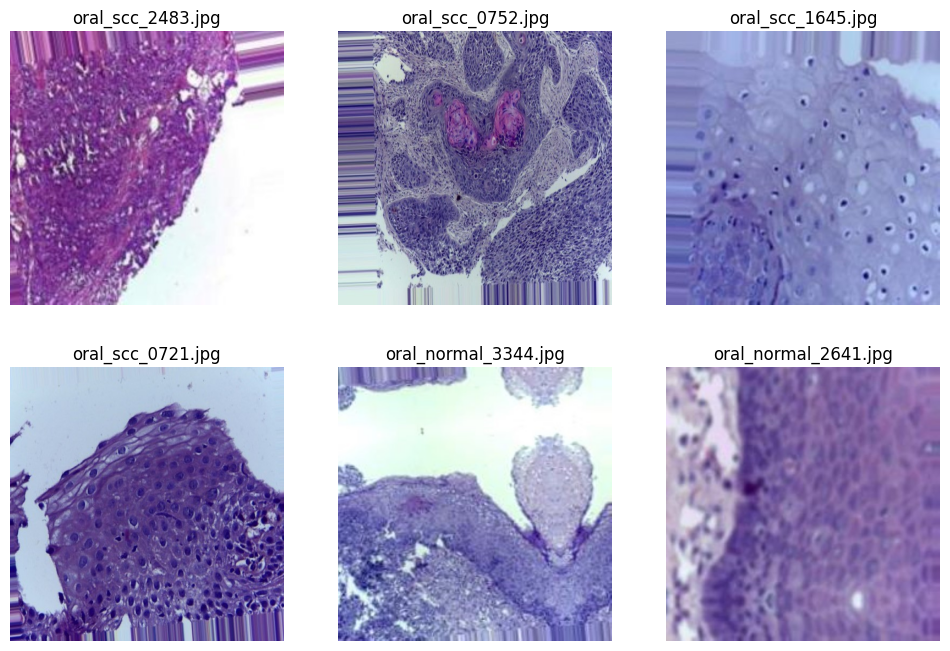

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 7000/7000 [01:14<00:00, 93.76it/s] 

Mean: tensor([0.5546, 0.5160, 0.7295])
Std: tensor([0.1617, 0.1924, 0.1222])


In [7]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [10]:

EPOCH = 25                 # 第一階段的 Epoch 數量

best_model_path = "best_oral_cancer_model.pth"

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading ResNet50 model...")
model = models.resnet50(pretrained=True)

# 凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 最後的分類層
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 2) # (normal, scc)

model = model.to(device)

# --- Training ---
print("\n--- Training  ---")

criterion = nn.CrossEntropyLoss()

# 優化器 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train() 
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    # 🔥 [新增] 將數據存入 history (.item() 將 tensor 轉為數值)
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 1 Epoch {epoch+1}/{EPOCH} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")
        
print("finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]



--- Training  ---


Epoch 1/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:19<00:00,  2.41it/s, loss=0.475]


Phase 1 Epoch 1/25 | Train Loss: 0.5420 Acc: 0.7204 | Val Loss: 0.5353 Acc: 0.7240
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7240


Epoch 2/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s, loss=0.629]


Phase 1 Epoch 2/25 | Train Loss: 0.4637 Acc: 0.7791 | Val Loss: 0.4580 Acc: 0.7907
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7907


Epoch 3/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.93it/s, loss=0.41] 


Phase 1 Epoch 3/25 | Train Loss: 0.4604 Acc: 0.7766 | Val Loss: 0.4259 Acc: 0.8040
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8040


Epoch 4/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s, loss=0.793]


Phase 1 Epoch 4/25 | Train Loss: 0.4576 Acc: 0.7864 | Val Loss: 0.5517 Acc: 0.7447


Epoch 5/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.00it/s, loss=0.37] 


Phase 1 Epoch 5/25 | Train Loss: 0.4306 Acc: 0.7984 | Val Loss: 0.4034 Acc: 0.8160
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8160


Epoch 6/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s, loss=0.317]


Phase 1 Epoch 6/25 | Train Loss: 0.4213 Acc: 0.8096 | Val Loss: 0.4188 Acc: 0.8067


Epoch 7/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s, loss=0.46] 


Phase 1 Epoch 7/25 | Train Loss: 0.4108 Acc: 0.8104 | Val Loss: 0.3912 Acc: 0.8213
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8213


Epoch 8/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.00it/s, loss=0.302]


Phase 1 Epoch 8/25 | Train Loss: 0.3995 Acc: 0.8183 | Val Loss: 0.3681 Acc: 0.8240
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8240


Epoch 9/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.06it/s, loss=0.532]


Phase 1 Epoch 9/25 | Train Loss: 0.4094 Acc: 0.8157 | Val Loss: 0.4970 Acc: 0.7813


Epoch 10/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.03it/s, loss=0.484]


Phase 1 Epoch 10/25 | Train Loss: 0.3996 Acc: 0.8173 | Val Loss: 0.4195 Acc: 0.8047


Epoch 11/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.06it/s, loss=0.275]


Phase 1 Epoch 11/25 | Train Loss: 0.4127 Acc: 0.8136 | Val Loss: 0.3527 Acc: 0.8427
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8427


Epoch 12/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s, loss=0.254]


Phase 1 Epoch 12/25 | Train Loss: 0.4037 Acc: 0.8129 | Val Loss: 0.3443 Acc: 0.8487
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8487


Epoch 13/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.93it/s, loss=0.212]


Phase 1 Epoch 13/25 | Train Loss: 0.3921 Acc: 0.8229 | Val Loss: 0.3759 Acc: 0.8273


Epoch 14/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.97it/s, loss=0.326]


Phase 1 Epoch 14/25 | Train Loss: 0.4140 Acc: 0.8144 | Val Loss: 0.3708 Acc: 0.8327


Epoch 15/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.04it/s, loss=0.159]


Phase 1 Epoch 15/25 | Train Loss: 0.3957 Acc: 0.8193 | Val Loss: 0.3405 Acc: 0.8433


Epoch 16/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s, loss=0.404]


Phase 1 Epoch 16/25 | Train Loss: 0.3791 Acc: 0.8287 | Val Loss: 0.3702 Acc: 0.8267


Epoch 17/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.93it/s, loss=0.426]


Phase 1 Epoch 17/25 | Train Loss: 0.3777 Acc: 0.8273 | Val Loss: 0.4298 Acc: 0.8100


Epoch 18/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s, loss=0.31] 


Phase 1 Epoch 18/25 | Train Loss: 0.3907 Acc: 0.8197 | Val Loss: 0.3359 Acc: 0.8453


Epoch 19/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.96it/s, loss=0.344]


Phase 1 Epoch 19/25 | Train Loss: 0.3731 Acc: 0.8326 | Val Loss: 0.3294 Acc: 0.8500
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8500


Epoch 20/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.97it/s, loss=0.371]


Phase 1 Epoch 20/25 | Train Loss: 0.3671 Acc: 0.8354 | Val Loss: 0.3522 Acc: 0.8367


Epoch 21/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.54it/s, loss=0.513]


Phase 1 Epoch 21/25 | Train Loss: 0.3707 Acc: 0.8316 | Val Loss: 0.3598 Acc: 0.8320


Epoch 22/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s, loss=0.559]


Phase 1 Epoch 22/25 | Train Loss: 0.3628 Acc: 0.8374 | Val Loss: 0.3277 Acc: 0.8433


Epoch 23/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.509]


Phase 1 Epoch 23/25 | Train Loss: 0.3557 Acc: 0.8411 | Val Loss: 0.3860 Acc: 0.8280


Epoch 24/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s, loss=0.271]


Phase 1 Epoch 24/25 | Train Loss: 0.3566 Acc: 0.8396 | Val Loss: 0.3118 Acc: 0.8600
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8600


Epoch 25/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s, loss=0.703]

Phase 1 Epoch 25/25 | Train Loss: 0.3541 Acc: 0.8434 | Val Loss: 0.4475 Acc: 0.7940
finished.


In [11]:
# 模型微調 
print("\n--- Fine-Tuning ---")

NUM_FINETUNE_EPOCHS = 20   # 第二階段的 Epoch 數量

# 載入第一階段的最佳模型
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from Phase 1 with Val Acc: {best_val_acc:.4f}")

# 解凍所有層
for param in model.parameters():
    param.requires_grad = True

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-5) # 學習率 0.00001

best_finetune_acc = best_val_acc 

for epoch in range(NUM_FINETUNE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    # 🔥 [新增] 繼續將數據存入同一個 history (接續 Phase 1)
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 2 Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_finetune_acc:
        best_finetune_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New BEST model saved (Fine-Tuning) to {best_model_path} with Val Acc: {best_finetune_acc:.4f}")

print(" Fine-tuning finished.")




--- Fine-Tuning ---
Loaded best model from Phase 1 with Val Acc: 0.8600


Epoch 1/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.07it/s, loss=0.245] 


Phase 2 Epoch 1/20 | Train Loss: 0.2820 Acc: 0.8766 | Val Loss: 0.2025 Acc: 0.9180
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9180


Epoch 2/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.96it/s, loss=0.105] 


Phase 2 Epoch 2/20 | Train Loss: 0.1792 Acc: 0.9297 | Val Loss: 0.1340 Acc: 0.9487
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9487


Epoch 3/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s, loss=0.213] 


Phase 2 Epoch 3/20 | Train Loss: 0.1270 Acc: 0.9513 | Val Loss: 0.0954 Acc: 0.9680
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9680


Epoch 4/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.97it/s, loss=0.0788] 


Phase 2 Epoch 4/20 | Train Loss: 0.1016 Acc: 0.9619 | Val Loss: 0.0789 Acc: 0.9693
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9693


Epoch 5/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.99it/s, loss=0.0943] 


Phase 2 Epoch 5/20 | Train Loss: 0.0784 Acc: 0.9709 | Val Loss: 0.0696 Acc: 0.9713
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9713


Epoch 6/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.04it/s, loss=0.0231] 


Phase 2 Epoch 6/20 | Train Loss: 0.0651 Acc: 0.9767 | Val Loss: 0.0573 Acc: 0.9760
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9760


Epoch 7/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.02it/s, loss=0.00131]


Phase 2 Epoch 7/20 | Train Loss: 0.0577 Acc: 0.9791 | Val Loss: 0.0566 Acc: 0.9767
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9767


Epoch 8/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.02it/s, loss=0.0728] 


Phase 2 Epoch 8/20 | Train Loss: 0.0437 Acc: 0.9837 | Val Loss: 0.0562 Acc: 0.9767


Epoch 9/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s, loss=0.0259] 


Phase 2 Epoch 9/20 | Train Loss: 0.0463 Acc: 0.9847 | Val Loss: 0.0522 Acc: 0.9813
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9813


Epoch 10/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.00it/s, loss=0.0205]  


Phase 2 Epoch 10/20 | Train Loss: 0.0386 Acc: 0.9846 | Val Loss: 0.0542 Acc: 0.9840
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9840


Epoch 11/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s, loss=0.152]   


Phase 2 Epoch 11/20 | Train Loss: 0.0391 Acc: 0.9863 | Val Loss: 0.0398 Acc: 0.9853
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9853


Epoch 12/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, loss=0.0889]  


Phase 2 Epoch 12/20 | Train Loss: 0.0352 Acc: 0.9876 | Val Loss: 0.0471 Acc: 0.9853


Epoch 13/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.99it/s, loss=0.00245] 


Phase 2 Epoch 13/20 | Train Loss: 0.0320 Acc: 0.9867 | Val Loss: 0.0486 Acc: 0.9840


Epoch 14/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.00103]


Phase 2 Epoch 14/20 | Train Loss: 0.0305 Acc: 0.9877 | Val Loss: 0.0417 Acc: 0.9873
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9873


Epoch 15/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s, loss=0.156]  


Phase 2 Epoch 15/20 | Train Loss: 0.0279 Acc: 0.9903 | Val Loss: 0.0451 Acc: 0.9860


Epoch 16/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.92it/s, loss=0.0168]  


Phase 2 Epoch 16/20 | Train Loss: 0.0302 Acc: 0.9884 | Val Loss: 0.0438 Acc: 0.9853


Epoch 17/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.96it/s, loss=0.0449]  


Phase 2 Epoch 17/20 | Train Loss: 0.0284 Acc: 0.9899 | Val Loss: 0.0527 Acc: 0.9820


Epoch 18/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.04it/s, loss=6.47e-5] 


Phase 2 Epoch 18/20 | Train Loss: 0.0273 Acc: 0.9891 | Val Loss: 0.0455 Acc: 0.9867


Epoch 19/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s, loss=0.000196]


Phase 2 Epoch 19/20 | Train Loss: 0.0230 Acc: 0.9920 | Val Loss: 0.0399 Acc: 0.9860


Epoch 20/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.88it/s, loss=0.0627]  

Phase 2 Epoch 20/20 | Train Loss: 0.0213 Acc: 0.9920 | Val Loss: 0.0434 Acc: 0.9840
 Fine-tuning finished.


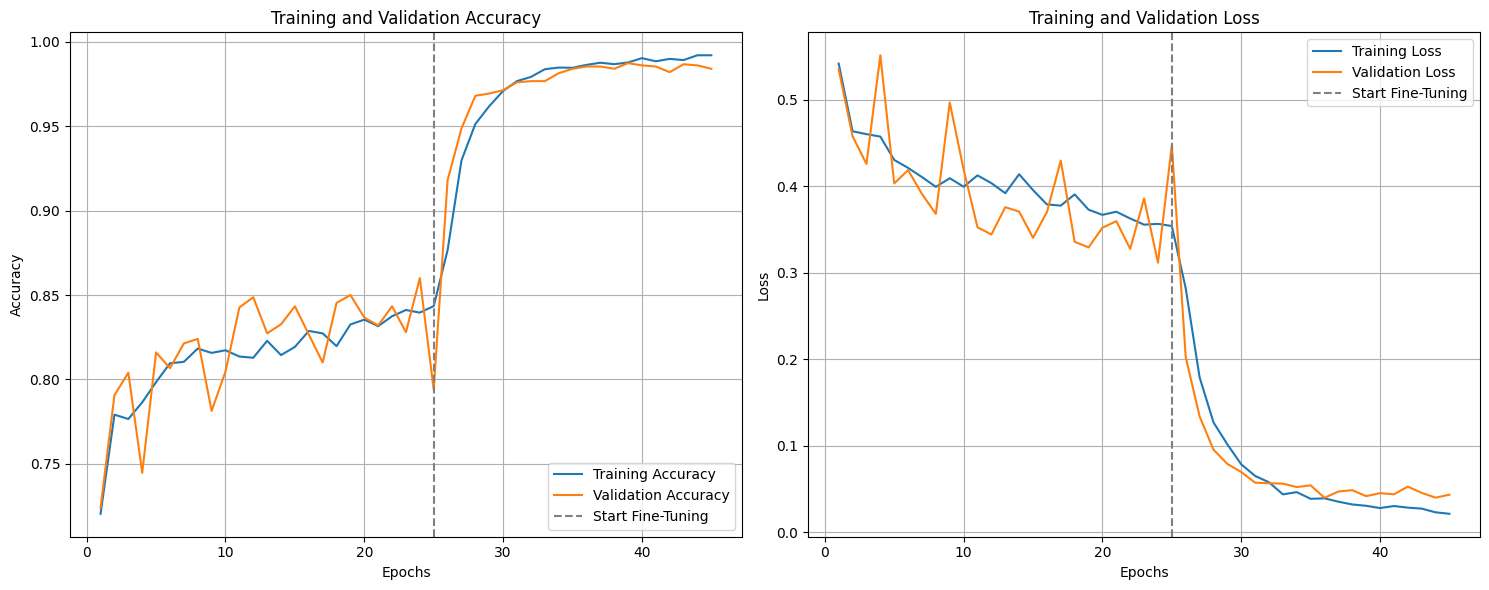

In [12]:
# ---  Learning Curve ---
def plot_learning_curves(history, phase1_epochs):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    

    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_learning_curves(history, phase1_epochs=EPOCH)

In [14]:
from torch.utils.data import ConcatDataset, DataLoader

full_train_dataset = ConcatDataset([train_dataset, val_dataset])

full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


model.load_state_dict(torch.load(best_model_path))


REFINE_EPOCHS = 20 
optimizer = optim.Adam(model.parameters(), lr=1e-5) # 保持微調的低學習率


for epoch in range(REFINE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    pbar = tqdm(full_train_loader, desc=f"Phase 3 - Epoch {epoch+1}/{REFINE_EPOCHS}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        
        pbar.set_postfix({'loss': loss.item()})
        
    epoch_acc = (train_corrects.double() / len(full_train_dataset)).item()
    print(f"   Refinement Train Acc: {epoch_acc:.4f}")

final_model_path = "final_refined_model.pth"
torch.save(model.state_dict(), final_model_path)


Phase 3 - Epoch 1/20: 100%|██████████| 266/266 [01:27<00:00,  3.03it/s, loss=0.0453]  


   Refinement Train Acc: 0.9864


Phase 3 - Epoch 2/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.000457]


   Refinement Train Acc: 0.9892


Phase 3 - Epoch 3/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.000133]


   Refinement Train Acc: 0.9885


Phase 3 - Epoch 4/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.00547] 


   Refinement Train Acc: 0.9916


Phase 3 - Epoch 5/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.00311] 


   Refinement Train Acc: 0.9906


Phase 3 - Epoch 6/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.000196]


   Refinement Train Acc: 0.9896


Phase 3 - Epoch 7/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.0587]  


   Refinement Train Acc: 0.9905


Phase 3 - Epoch 8/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.00605] 


   Refinement Train Acc: 0.9919


Phase 3 - Epoch 9/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.00947] 


   Refinement Train Acc: 0.9919


Phase 3 - Epoch 10/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.000877]


   Refinement Train Acc: 0.9936


Phase 3 - Epoch 11/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.000142]


   Refinement Train Acc: 0.9924


Phase 3 - Epoch 12/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.000204]


   Refinement Train Acc: 0.9931


Phase 3 - Epoch 13/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=8.59e-5] 


   Refinement Train Acc: 0.9935


Phase 3 - Epoch 14/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.00976] 


   Refinement Train Acc: 0.9932


Phase 3 - Epoch 15/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.0164]  


   Refinement Train Acc: 0.9945


Phase 3 - Epoch 16/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.000842]


   Refinement Train Acc: 0.9948


Phase 3 - Epoch 17/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.00108] 


   Refinement Train Acc: 0.9938


Phase 3 - Epoch 18/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.0469]  


   Refinement Train Acc: 0.9945


Phase 3 - Epoch 19/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.00149] 


   Refinement Train Acc: 0.9961


Phase 3 - Epoch 20/20: 100%|██████████| 266/266 [01:27<00:00,  3.04it/s, loss=0.0672]  

   Refinement Train Acc: 0.9939



--- Final Testing & Metrics Calculation ---


Testing: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s]


 Final Results
Accuracy  : 0.9860
Precision : 0.9946
Recall    : 0.9773
F1 Score  : 0.9859
------------------------------

 Report 
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       750
         SCC       0.99      0.98      0.99       750

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



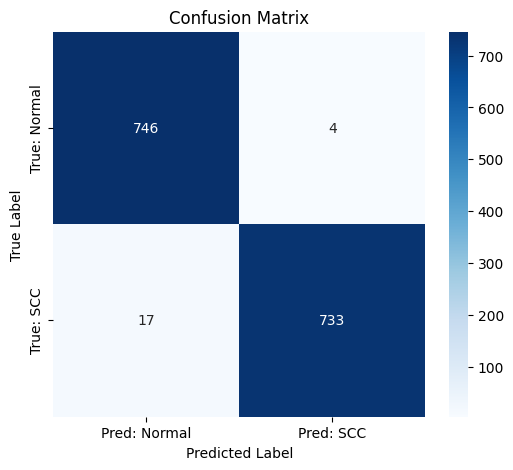

In [16]:
print("\n--- Final Testing & Metrics Calculation ---")

model.load_state_dict(torch.load(final_model_path))

model.eval()
model.to(device)


all_labels = []
all_preds = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print("\n" + "="*30)
print(f" Final Results")
print("="*30)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)


print("\n Report ")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'SCC']))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Normal', 'Pred: SCC'],
            yticklabels=['True: Normal', 'True: SCC'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()